In [97]:
from lenskit.datasets import ML100K
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn, user_knn
from lenskit import topn

In [98]:
import pandas as pd

In [99]:
%matplotlib inline

In [100]:
ml100k = ML100K('ml-100k')
ratings = ml100k.ratings
ratings.head()

,user,item,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [118]:
movies = ml100k.movies
movies["title"].head()

item
1     Toy Story (1995)
2     GoldenEye (1995)
3    Four Rooms (1995)
4    Get Shorty (1995)
5       Copycat (1995)
Name: title, dtype: object

In [102]:
algo_ii = item_knn.ItemItem(20)
algo_uu = user_knn.UserUser(20)
algo_als = als.BiasedMF(50)

In [103]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train)
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100)
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [119]:
all_recs = []
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test))
    all_recs.append(eval('UserUser', algo_uu, train, test))
    all_recs.append(eval('ALS', algo_als, train, test))

In [120]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs.head()

,item,score,user,rank,Algorithm
0,513,5.741943,4,1,ItemItem
1,59,5.578698,4,2,ItemItem
2,656,5.546707,4,3,ItemItem
3,1125,5.533543,4,4,ItemItem
4,641,5.523110,4,5,ItemItem


In [106]:
# alldata = [all_recs, movies]

# result = pd.concat(alldata)
# result.head()

In [121]:
test_data = pd.concat(test_data, ignore_index=True)

In [122]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.head()

nrecs      ndcg
user Algorithm                 
1    ALS        100.0  0.290745
     ItemItem   100.0  0.244476
     UserUser   100.0  0.196846
2    ALS        100.0  0.300705
     ItemItem   100.0  0.159272

In [123]:
results.groupby('Algorithm').ndcg.mean()

Algorithm
ALS         0.139939
ItemItem    0.105116
UserUser    0.066605
Name: ndcg, dtype: float64

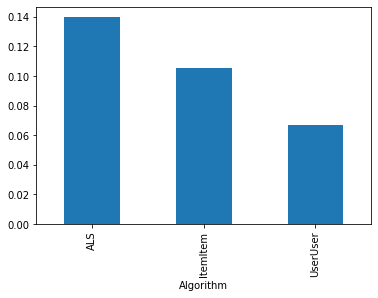

In [124]:
results.groupby('Algorithm').ndcg.mean().plot.bar()

In [125]:
joint_df = pd.merge(all_recs, movies, left_on='item', right_index = True)
 
print(joint_df[ ['user','item','title','score'] ])

        user  item                                            title     score
0          4   513                            Third Man, The (1949)  5.741943
120       23   513                            Third Man, The (1949)  4.398799
222       28   513                            Third Man, The (1949)  4.524310
307       30   513                            Third Man, The (1949)  4.969756
412       34   513                            Third Man, The (1949)  5.702631
...      ...   ...                                              ...       ...
278390   706  1044                                Paper, The (1994)  3.921113
276382   617  1455                               Outlaw, The (1943)  3.308297
277081   642  1621                            Butterfly Kiss (1995)  4.402973
278355   706  1033  Homeward Bound II: Lost in San Francisco (1996)  4.010649
281382   845  1033  Homeward Bound II: Lost in San Francisco (1996)  3.808462

[282900 rows x 4 columns]
